# ch05.11. 사이킷런 실습 - 분류모델 탐색
---
* 날짜:2022-05-26
* 이름:고민수

## 학습내용
    - 소프트맥스 회귀 프로세스를 이해한다.
    - 소프트맥스 함수를 구현한다.

## 학습자료
- [머신러닝 교과서 with파이썬, 사이킷런, 텐서플로](http://www.kyobobook.co.kr/product/detailViewKor.laf?mallGb=KOR&ejkGb=KOR&barcode=9791165215187)
- 3장. 사이킷런을 타고 떠나는 머신 러닝 분류 모델 투어
- [sckitlearn [1.12. Multiclass and multioutput algorithms]](https://scikit-learn.org/stable/modules/multiclass.html)

```
import numpy as np
import matplotlib.pyplot as plt
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### **데이터 준비 : Iris**

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

def iris_loader(n_classes, # 클래스 개수 지정 (2-이진, 3-다중) 
                features='', # 특징선택 (0,1: sepal 길이/너비, 2,3: petal 길이/너비)
                test_size=0.2, # 데이터 분할시 테스트 사이즈
                rs=1, # 데이터 분할시 랜덤시드
                scale=True): # 스케일 여부
  
  iris = load_iris()
  X = iris.data # (n, 4)
  y = iris.target # (n,) y값은 0, 1, 2
  columns = iris.feature_names # 특징 이름 {특징1, 특징2, 특징3, 특징4}
  labels = iris.target_names # 꽃 종류 {1번꽃, 2번꽃, 3번꽃}
  
  # 클래스 개수 지정
  if n_classes == 2: # 이진분류 -> X, y 중에서 y 가 2가 아닌 데이터
    mask = y!=2
    X = X[mask]
    y = y[mask]
    labels = labels[:2]
  else: pass # 2가 아닐 땐 원본 데이터 (3가지 종류)

  # 특징 지정
  if features == 'sepal':
    X = X[:, :2 ]
    columns = columns[:2]
  elif features =='petal':
    X = X[:, 2:]
    columns = columns[2:]
  else: pass

  # 데이터 분할
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size,
                                                      random_state=rs)
  # 스케일링 (X 에만)
  if scale: # scale: True/False
    sc_x = StandardScaler()
    X_train = sc_x.fit_transform(X_train)
    X_test = sc_x.transform(X_test)

  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, features, labels)
  return X_train, X_test, y_train, y_test, columns, labels

In [ ]:
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'sepal')

(120, 2) (30, 2) (120,) (30,) sepal ['setosa' 'versicolor' 'virginica']


## 회귀모델
---



<p align='center'>
<img src=https://camo.githubusercontent.com/c4c08b5281e9a087e3db007b8bf2baaca4b64b8cc8f109e59439be7b3a9694ed/68747470733a2f2f6769742e696f2f4a746d3232?raw=true width=520>
</p>

### | 사이킷런을 이용한 구현
[사이킷런 - LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression)
```
linear_model.LogisticRegression(penalty='l2', # 가중치 규제 항
                                dual=False, 
                                tol=0.0001, 
                                C=1.0, # 가중치 규제 강도
                                fit_intercept=True, # 편향 추가
                                intercept_scaling=1,
                                class_weight=None,
                                random_state=None, 
                                solver='lbfgs', # 최적화 
                                max_iter=100, 
                                multi_class='auto', 
                                verbose=0, 
                                warm_start=False, 
                                n_jobs=None, 
                                l1_ratio=None)

```


* 작은 데이터 세트의 경우 `liblinear`가 좋은 선택인 반면, 큰 데이터 세트의 경우 `sag`와 `saga`가 더 빠릅니다.

* 다중 클래스 문제의 경우 `newton-cg`, `sag`, `saga` 및 `lbfgs`만 다항 손실을 처리합니다.

* 알고리즘 별 패털티 선택 가이드 라인
  * `newton-cg` : [‘l2’, ‘none’]
  * `lbfgs` : [‘l2’, ‘none’]
  * `liblinear` : [‘l1’, ‘l2’]
  * `sag` : [‘l2’, ‘none’]
  * `saga` : [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]


### **| 이진분류**

* 'sepal' 관련 특성을 이용하여 'setosa', 'versicolor' 두 종류 구분
* 최적화 방식 `liblinear` 사용

In [ ]:
from sklearn.linear_model import LogisticRegression

# 데이터 로드
X_train, X_test, y_train, y_test, columns, labels = iris_loader(2, 'sepal')

# 모델 학습
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
# 성능 평가 (분류: accuracy)
print('Acc:', model.score(X_test, y_test))

(80, 2) (20, 2) (80,) (20,) sepal ['setosa' 'versicolor']
Acc: 1.0


#### **혼돈행렬**

* 함수 구현

In [ ]:
columns, labels

(['sepal length (cm)', 'sepal width (cm)'],
 array(['setosa', 'versicolor'], dtype='<U10'))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def draw_cm(model, X, y, title=''):
  y_pred = model.predict(X)
  cm = confusion_matrix(y, y_pred) # 혼돈 행렬 구하기
  ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap='Blues')
  if title: plt.title(title)

* 혼돈 행렬 시각화

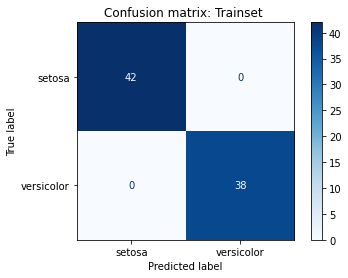

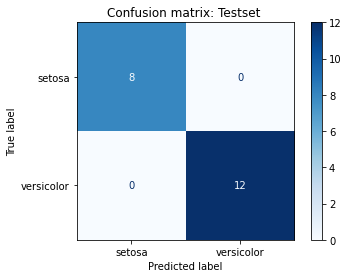

In [ ]:
draw_cm(model, X_train, y_train, 'Confusion matrix: Trainset ')
plt.show()
draw_cm(model, X_test, y_test, 'Confusion matrix: Testset ')
plt.show()

* 예측 오차 (ERR)

\begin{split}
ERR = \frac{잘못된 예측 개수}{전체 샘플 개수}
\end{split}

In [ ]:
err = ( 0 + 0)/20
err

0.0

* 예측 정확도 (ACC)

\begin{split}
ACC = \frac{잘된 예측 개수}{전체 샘플 개수} = 1-ERR
\end{split}

In [ ]:
acc = ( 8 + 12) / 20
acc

1.0

#### **결정경계**

In [ ]:
from matplotlib.colors import ListedColormap

def draw_decision_region(model, X, y, 
                         X_test=[], y_test=[], 
                         features=[], labels=[]): # 결정경계

  colors = ('orangered', 'dodgerblue', 'limegreen', 'fuchsia', 'blueviolet')
  cmap = ListedColormap(colors[:len(np.unique( y))])

  x0mn, x0mx = X[:,0].min() -1, X[:,0].max() +1
  x1mn, x1mx = X[:,1].min() -1, X[:,1].max() +1
  x0 = np.arange(x0mn, x0mx, 0.02)
  x1 = np.arange(x1mn, x1mx, 0.02)
  #print('* arange', x0.shape, x1.shape)
  X0, X1 = np.meshgrid(x0, x1)
  #print('* meshgrid', x0.shape, x1.shape)
  x0, x1 = X0.ravel(), X1.ravel()
  #print('* ravel', x0.shape, x1.shape)
  x_every = np.array([x0, x1]).T
  #print('* concat', x_every.shape)
  y_pred = model.predict(x_every)
  #print('* y_pred', y_pred.shape)
  Y_pred = y_pred.reshape(X0.shape)
  #print('* y_pred', y_pred.shape)

  if not len(labels): labels=[i for i in range(len(np.unique(y)))]
  plt.contourf(X0, X1, Y_pred, alpha=0.4, cmap=cmap )
  for idx, c in enumerate(np.unique(y)):
    plt.scatter(x = X[y == c, 0], 
                y = X[y == c, 1],
                alpha=0.8,
                c=colors[idx],
                label=labels[idx],
                marker='x',
                linewidth=2)
  if len(X_test):
    for idx, c in enumerate(np.unique(y_test)):
      plt.scatter(x = X_test[y_test == c, 0], 
                  y = X_test[y_test == c, 1],
                  alpha=0.8,
                  c=colors[idx],
                  marker='o',
                  edgecolor='k',
                  linewidth=2)
  
  if features:
    plt.xlabel(features[0])
    plt.ylabel(features[1])
  plt.legend()

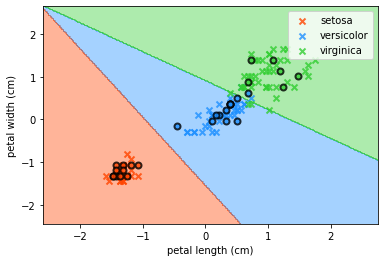

In [ ]:
draw_decision_region(model, 
                     X_train, y_train, 
                     X_test, y_test,
                     features=columns, 
                     labels=labels)

### **| 다중클래스 분류**

* `sepal` 관련 특성을 이용하여 3개 클래스 분류
* 최적화 방식 `lbfgs` 사용
* `multi_class`는 `multi_nomial`로 지정
* 정확도 출력
* 혼돈 행렬 시각화
* 결정경계 시각화

(120, 2) (30, 2) (120,) (30,) sepal ['setosa' 'versicolor' 'virginica']


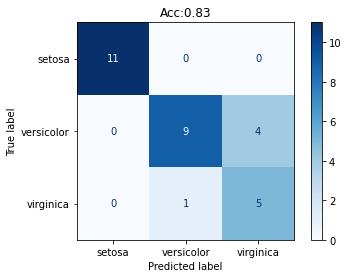

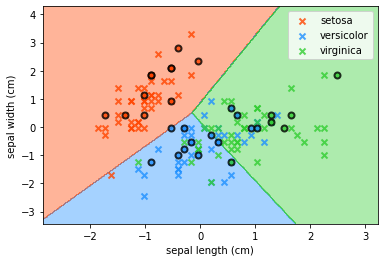

In [ ]:
from sklearn.linear_model import LogisticRegression

# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'sepal')
# 학습
model = LogisticRegression(solver='lbfgs', 
                           multi_class='multinomial')
model.fit(X_train, y_train)
# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'Acc:{np.round(acc,2)}')
plt.show()
# 결정경계 시각화
draw_decision_region(model, X_train, y_train,
                     X_test, y_test,
                     features=columns,
                     labels=labels)
plt.show()

#### **예제 01**

* 'petal' 관련 특성을 이용하여 3개 클래스 분류
* 모델
  * 최적화 방식 `saga` 사용
  * `multi_class`는 `multinomial`로 지정
* 평가
  * 정확도 출력
  * 혼돈 행렬 시각화
  * 결정경계 시각화

(120, 2) (30, 2) (120,) (30,) petal ['setosa' 'versicolor' 'virginica']


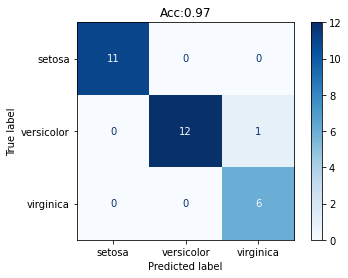

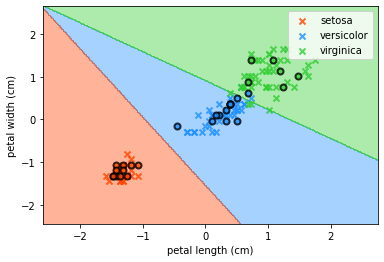

In [ ]:
from sklearn.linear_model import LogisticRegression

# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'petal')
# 학습
model = LogisticRegression(solver='saga', 
                           multi_class='multinomial')
model.fit(X_train, y_train)
# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'Acc:{np.round(acc,2)}')
plt.show()
# 결정경계 시각화
draw_decision_region(model, X_train, y_train,
                     X_test, y_test,
                     features=columns,
                     labels=labels)
plt.show()

#### **예제 02**

* 모든 특성(4개)을 이용하여 3개 클래스 분류
* 모델
  * 최적화 방식 `lbfgs` 사용
  * `multi_class`는 `multi_nomial`로 지정
* 평가
  * 정확도 출력
  * 혼돈 행렬 시각화

In [ ]:
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3)

(120, 4) (30, 4) (120,) (30,)  ['setosa' 'versicolor' 'virginica']


(120, 4) (30, 4) (120,) (30,)  ['setosa' 'versicolor' 'virginica']


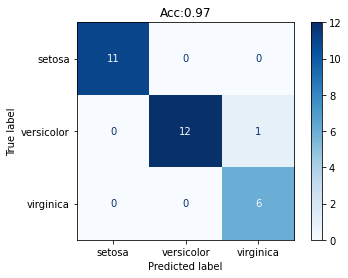

In [ ]:
from sklearn.linear_model import LogisticRegression

# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3)
# 학습
model = LogisticRegression(solver='saga', 
                           multi_class='multinomial')
model.fit(X_train, y_train)
# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'Acc:{np.round(acc,2)}')
plt.show()

## 결정트리 (Decision tree)
---

<p align='center'>
<img src=https://camo.githubusercontent.com/436f5e942773563b85e5d640e5714c367e11cf08edc9da5b41598ab7dea951c9/68747470733a2f2f6769742e696f2f4a746d3231
?raw=true width=600>
</p>

훈련 데이터의 특성(속성)을 기반으로 샘플의 클래스 레이블을 추정할 수 있는 일련의 질문을 학습

데이터의 특성이 범주형이 아니라 실수라면 특정 값을 기준으로 크고 작음의 범주로 나누게 된다.

데이터 분할 기준은 정보이득 (Information Gain, IG)의  최대화이며, 정보이득은 불순도로 부터 구해진다.

불순도(Impurity) 란 특정 영역 내에 클래스가 얼마나 섞여있는지를 나타내는 지표

리프 노드(leaf node)가 순수해질 때까지 모든 자식 노드에서 분할 작업을 반복한다.

너무 많은, 깊은 트리가 만들어 지면 과적합의 가능성이 높아지기 때문에 트리의 최대 깊이를 제한하여 트리를 가지치기(pruning) 한다.






### **| 불순도 지표: 엔트로피(Entropy)**

\begin{split}
I_H(t) = -\sum_{i=1}^{c}p(i|t)log_2p(i|t)
\end{split}

* $p(i|t)$ : 
* $I_H$ 의 범위 : 
* $I_H = 1 $: 
* $I_H = 0 $: 
* 불순도(엔트로피)


In [ ]:
# 이진 분류
def entropy(p): # p는 0~1
  return - p * np.log2(p) - (1-p) * np.log2(1-p)

In [ ]:
p = np.arange(0.01, 1, 0.1)
entropy(p)

array([0.08079314, 0.49991596, 0.74148274, 0.89317346, 0.97650047,
       0.99971144, 0.96479955, 0.86872125, 0.70147146, 0.43646982])

![](https://github.com/yebiny/Lecture-Deeplearning/blob/main/imgs/bdt_%EB%B6%88%EC%88%9C%EB%8F%84.PNG?raw=true)

### **| 불순도 지표: 지니 불순도(Gini impurity, $I_G$)**

\begin{split}
I_G(t) = \sum_{i=1}^{c}p(i|t)(1-p(i|t)) 
\end{split}

* $p(i|t)$ : 0 부터 1의 확률
* $I_G$ 의 범위 : 0 부터 0.5
* $I_G = 0.5 $: 클래스가 균등하게 존재
* $I_G = 0 $: 클래스가 한쪽으로 치우쳐 존재
* 불순도(지니) 가 낮을 수록 그 영역에 한 클래스가 우세


In [ ]:
def gini(p):
  return p*(1-p) + (1-p)*(1-(1-p))

In [ ]:
gini(p)

array([0.0198, 0.1958, 0.3318, 0.4278, 0.4838, 0.4998, 0.4758, 0.4118,
       0.3078, 0.1638])

### **| 불순도 지표: 분류 오차(Classification error, $I_E$)**

\begin{split}
I_H(E) = 1-max\{p(i|t)\} 
\end{split}




In [ ]:
def error(p):
  return 1-np.max( [p, 1-p] )

In [ ]:
[error(pi) for pi in p]

[0.010000000000000009,
 0.10999999999999999,
 0.20999999999999996,
 0.31000000000000005,
 0.41000000000000003,
 0.49,
 0.3899999999999999,
 0.2899999999999999,
 0.18999999999999995,
 0.08999999999999997]

#### **p값에 따른 불순도 지표 변화**

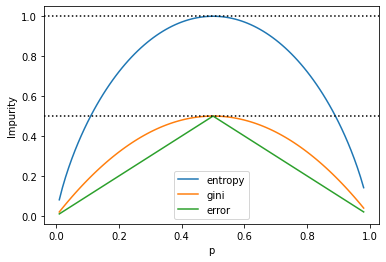

In [ ]:
p = np.arange(0.01, 0.99, 0.01)
plt.plot(p, entropy(p), label='entropy') # p값에 따른 entropy
plt.plot(p, gini(p), label='gini') # p값에 따른 gini
plt.plot(p, [error(pi) for pi in p], label='error') # p값에 따른 error
plt.axhline(y=1,c='k', linestyle=':')
plt.axhline(y=.5,c='k', linestyle=':')
plt.xticks()
plt.xlabel('p')
plt.ylabel('Impurity')
plt.legend()
plt.show()

### **| 정보이득 (Information Gain)**

결정트리의 목적함수는 아래와 같습니다. 이 목적 함수는 각 분할이 정보 이득을 최대화 하도록 합니다. 

\begin{split}
IG(D_p, f) = I(D_p) - \sum_{j=1}^m \frac{N_j}{N_p}I(D_j)
\end{split}

\begin{split}
정보 이득  = (부모노드의 불순도) - 정규화된 (자식 노드의 불순도)
\end{split}

* $f$: 분할에 사용되는 특성(속성, feature, 변수.. )
* $D_p$ : 부모 노드의 데이터셋
* $D_j$ : j번째 자식 노드의 데이터셋
* $I$: 불순도 (Impurity)
* $N_p$: 부모 노드의 전체 샘플 개수
* $N_j$: j번째 자식 노드의 전체 샘플 개수
* 정보이득이 높다 : 분할 결과가 좋다
* 정보이득이 낮다 : 분할 결과가 좋지 않다.

In [ ]:
IG = I_p - (N_1/N_p)*I_1 - (N_2/N_p)*I_2

#### **예제 03**

다음 조건으로 분할이 진행되었을 때 정보이득을 계산하세요.

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DataAnalysis/blob/main/imgs/ch0510-01.PNG?raw=true
?raw=true width=750>
</p>

#### **예제 04**

다음 A, B 조건으로 분할이 진행되었을 때 각각의 정보이득을 계산하고 어떤 분할이 더 적합한지 계산하세요.

<p align='center'>
<img src=https://camo.githubusercontent.com/c0c17de8d888513d12a1aa27c226d8e0e50a1ea02496719190899ce57ea5ca7a/68747470733a2f2f6769742e696f2f4a746d3244?raw=true
?raw=true width=600>
</p>

In [ ]:
# A, 지표:entropy
p_p = 40/80 # 부모노드 한쪽 클래스 확률
I_p = np.round(entropy(p_p),2) # 부모노드 불순도

p_1 = 30/40 # 자식1 노드 한쪽 클래스 확률
I_1 = np.round(entropy(p_1),2) # 자식1 노드 불순도

p_2 = 10/40 # 자식2 노드 한쪽 클래스 확률
I_2 = np.round(entropy(p_2),2) # 자식2 노드 불순도

print(I_p, I_1, I_2) # 부모, 자식1, 자식2 불순도
# Information gain
N_p, N_1 , N_2 = 80, 40, 40 # 부모, 자식1, 자식2 전체샘플 개수
print(N_p, N_1, N_2)

IG = I_p - (N_1/N_p)*I_1 - (N_2/N_p)*I_2
IG = np.round(IG, 2)
print('IG:',IG)

1.0 0.81 0.81
80 40 40
IG: 0.19


In [ ]:
# B, 지표:entropy
p_p = 40/80 # 부모노드 한쪽 클래스 확률
I_p = np.round(entropy(p_p),2) # 부모노드 불순도

p_1 = 20/60 # 자식1 노드 한쪽 클래스 확률
I_1 = np.round(entropy(p_1),2) # 자식1 노드 불순도

p_2 = 20/20 # 자식2 노드 한쪽 클래스 확률
p_2 = 0.99999 # 0 방지
I_2 = np.round(entropy(p_2),2) # 자식2 노드 불순도

print(I_p, I_1, I_2) # 부모, 자식1, 자식2 불순도
# Information gain
N_p, N_1 , N_2 = 80, 40, 40 # 부모, 자식1, 자식2 전체샘플 개수
print(N_p, N_1, N_2)

IG = I_p - (N_1/N_p)*I_1 - (N_2/N_p)*I_2
IG = np.round(IG, 2)
print(p_2)
print('IG:',IG)

1.0 0.92 0.0
80 40 40
0.99999
IG: 0.54


### | 사이킷런을 이용한 구현

[사이킷런 - DecisionTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreeclassifier#sklearn.tree.DecisionTreeClassifier)
```
tree.DecisionTreeClassifier(*, criterion='gini',  # 불순도 지표 {entropy}
                           splitter='best', 
                           max_depth=None, # 트리의 깊이 제한
                           min_samples_split=2, 
                           min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0,
                           max_features=None, 
                           random_state=None, 
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.0,
                           class_weight=None, 
                           ccp_alpha=0.0)
```

* 'petal' 관련 특성으로 3개 멀티클래스 분류
* 모델
  * 지니 불순도 사용
  * 최대 트리 깊이 5
* 평가
  * 정확도 계산
  * 혼돈행렬 시각화
  * 결정경계 시각화
  * 결정트리 시각화

(120, 2) (30, 2) (120,) (30,) petal ['setosa' 'versicolor' 'virginica']


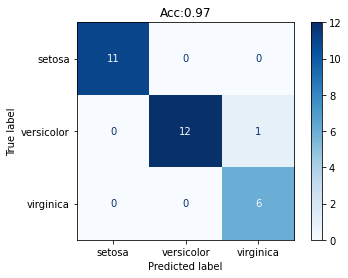

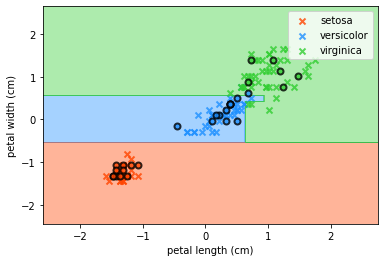

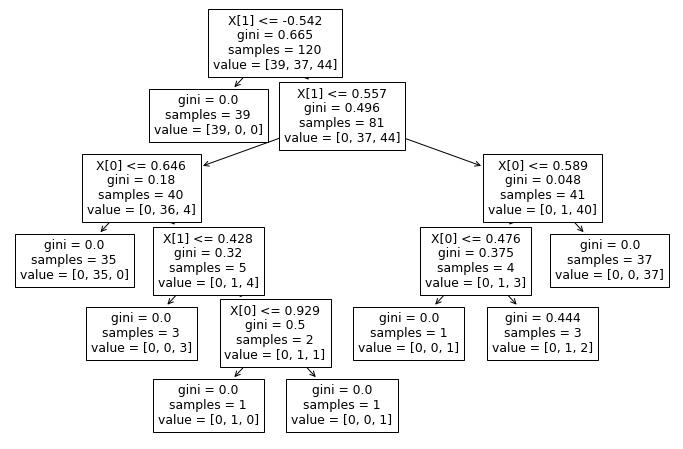

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'petal')
# 학습
model = DecisionTreeClassifier(criterion='gini', 
                               max_depth=5)
model.fit(X_train, y_train)
# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'Acc:{np.round(acc,2)}')
plt.show()
# 결정경계 시각화
draw_decision_region(model, X_train, y_train,
                     X_test, y_test,
                     features=columns,
                     labels=labels)
plt.show()
# 트리 시각화
plt.figure(figsize=(12,8))
plot_tree(model)
plt.show()

#### **예제 05**

* 'sepal' 관련 특성으로 3개 멀티클래스 분류
* 모델
  * 지니 불순도 사용
  * 최대 트리 깊이 4
* 평가
  * 정확도 계산
  * 혼돈행렬 시각화
  * 결정경계 시각화
  * 결정트리 시각화


(120, 2) (30, 2) (120,) (30,) sepal ['setosa' 'versicolor' 'virginica']


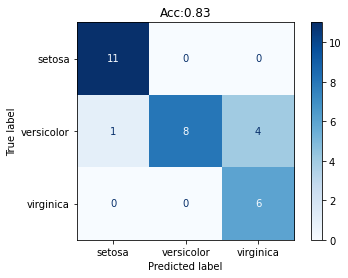

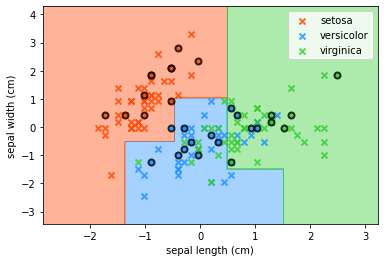

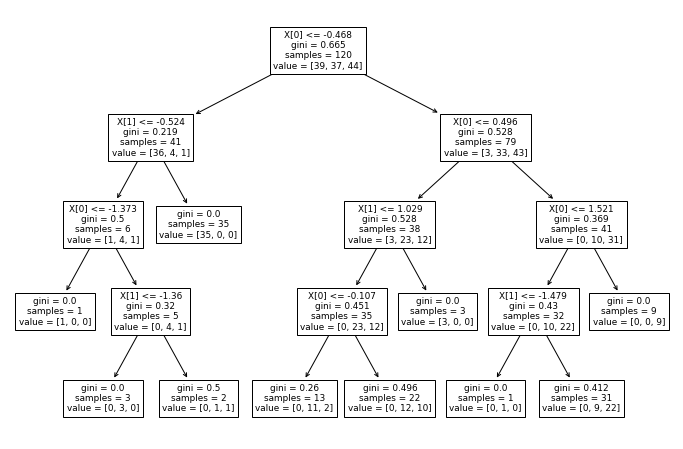

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'sepal')
# 학습
model = DecisionTreeClassifier(criterion='gini', 
                               max_depth=4)
model.fit(X_train, y_train)
# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'Acc:{np.round(acc,2)}')
plt.show()
# 결정경계 시각화
draw_decision_region(model, X_train, y_train,
                     X_test, y_test,
                     features=columns,
                     labels=labels)
plt.show()
# 트리 시각화
plt.figure(figsize=(12,8))
plot_tree(model)
plt.show()

#### **예제 06**

* 'sepal' 관련 특성으로  3개 멀티클래스 분류
* 모델
  * 엔트로피 불순도 사용
  * 최대 트리 깊이 3
* 평가
  * 정확도 계산
  * 혼돈행렬 시각화
  * 결정경계 시각화
  * 결정트리 시각화

(120, 2) (30, 2) (120,) (30,) petal ['setosa' 'versicolor' 'virginica']


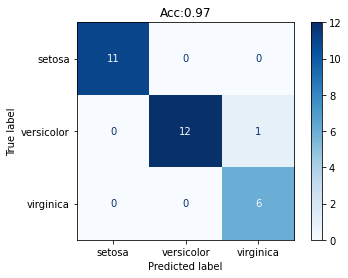

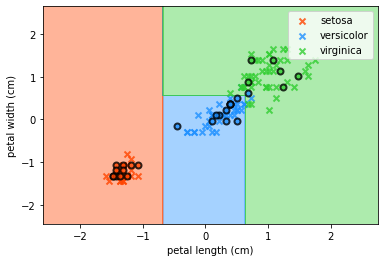

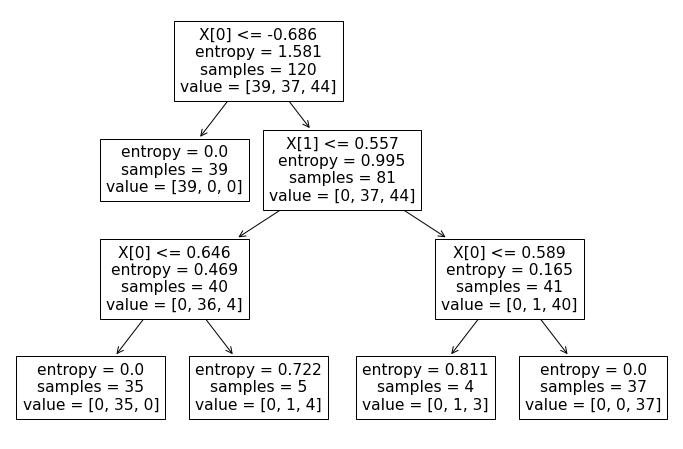

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'petal')
# 학습
model = DecisionTreeClassifier(criterion='entropy', 
                               max_depth=3)
model.fit(X_train, y_train)
# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'Acc:{np.round(acc,2)}')
plt.show()
# 결정경계 시각화
draw_decision_region(model, X_train, y_train,
                     X_test, y_test,
                     features=columns,
                     labels=labels)
plt.show()
# 트리 시각화
plt.figure(figsize=(12,8))
plot_tree(model)
plt.show()

## 서포트 벡터 머신 (Support Vector Machine)
---

서포트 벡터 머신(Support Vector Machine, SVM)은 강력하고 널리 사용되는 학습 알고리즘으로, 퍼셉트론 계열의 알고리즘을 확장 시킨 개념으로 생각 할 수 있다.

* 퍼셉트론의 아이디어: 분류 오차의 최소화
* 서포트 벡터 머신의 아이디어: 마진(margine)의 최대화

이 때 마진은 결정 경계(초평면)과 초평면에 가장 가까운 훈련 샘플 사이 거리로 정의

이 때 가장 가까운 샘플을 서포트 벡터(support vector)라 한다.


<p align='center'>
<img src=https://camo.githubusercontent.com/c63b819ba8417477499bd6b7017f4433d7362f1bbfab22035ce37ab6e4889b1b/68747470733a2f2f6769742e696f2f4a746d3272
?raw=true width=800>
</p>







### **| 제약 조건**
---
- 모든 샘플이 정확하게 분류 되었을 때, 

\begin{split}
w_o + w^Tx^{(i)} \geq 1 
\\
w_o + w^Tx^{(i)} \leq -1 
\end{split}


### **| 목적 함수** 
---
- 마진(margin)을 최대화

\begin{split}
\frac{w^T(x_{pos}-x_{neg})}{||w||_2}=\frac{2}{||w||_2}
\end{split}


### | 사이킷런을 이용한 구현

[사이킷런 - SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC)
```
svm.SVC(C=1.0, 규제강도
        kernel='rbf', linear, poly, rbf:가우시안, sigmoid
        degree=3, 
        gamma='scale', 가우시안일땐 구의 크기를 제한(규제)
        coef0=0.0, 
        shrinking=True, 
        probability=False, 
        tol=0.001, 
        cache_size=200, 
        class_weight=None, 
        verbose=False, 
        max_iter=- 1, 
        decision_function_shape='ovr', 
        break_ties=False, 
        random_state=None)
```

* 'petal' 관련 특성으로  멀티클래스 분류
* 모델
  * `kernel` = 'linear'
  * `C` = 1
* 평가
  * 정확도 계산
  * 혼돈행렬 시각화
  * 결정경계 시각화

(120, 2) (30, 2) (120,) (30,) petal ['setosa' 'versicolor' 'virginica']


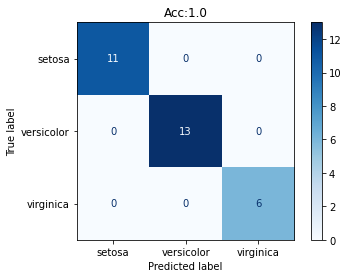

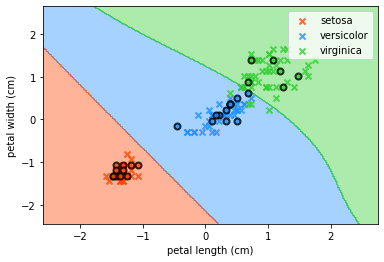

In [ ]:
from sklearn.svm import SVC

# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'petal')
# 학습
model = SVC(kernel= "poly", C=1)
model.fit(X_train, y_train)
# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'Acc:{np.round(acc,2)}')
plt.show()
# 결정경계 시각화
draw_decision_region(model, X_train, y_train,
                     X_test, y_test,
                     features=columns,
                     labels=labels)
plt.show()

#### **예제 07**

* 'sepal' 관련 특성으로  3개 멀티클래스 분류
* 모델
  * `kernel` = 'linear'
  * `C` = 0.01, 0.1, 1, 10, 100 일때, 각각에 대한 모델 학습 및 평가
* 평가
  * 정확도 계산
  * 혼돈행렬 시각화
  * 결정경계 시각화

(120, 2) (30, 2) (120,) (30,) petal ['setosa' 'versicolor' 'virginica']


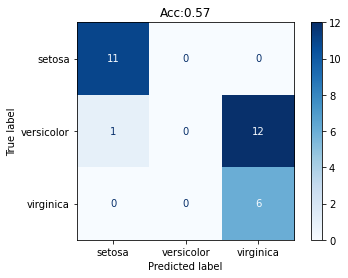

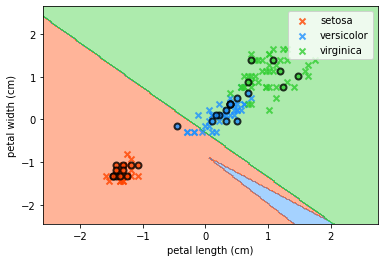

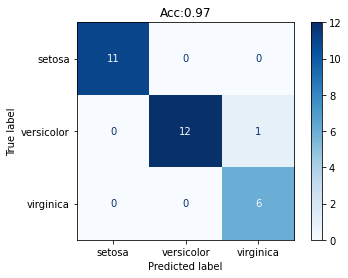

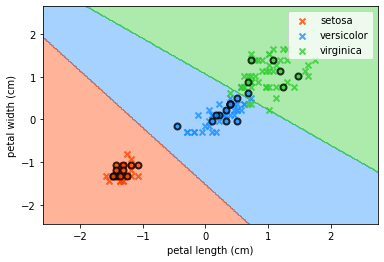

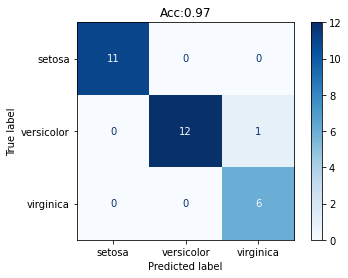

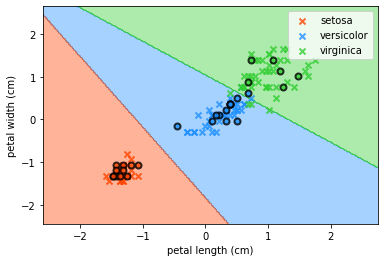

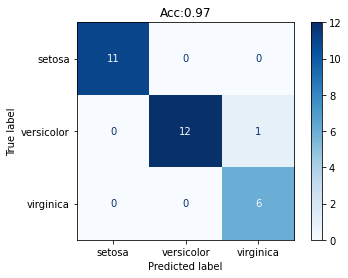

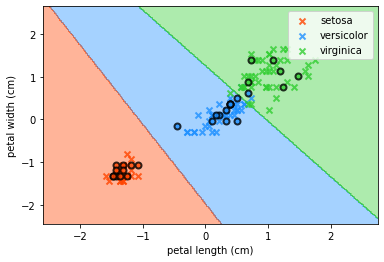

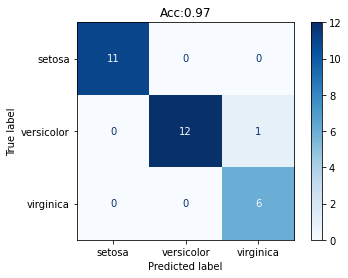

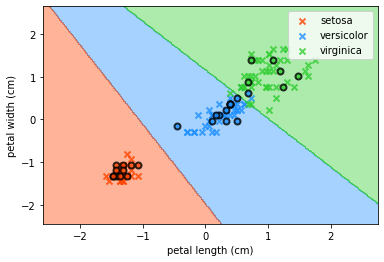

In [ ]:
# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'petal')
# 학습
Cs = [0.01,0.1,1,10,100]
for C in Cs:
    model = SVC(kernel= "linear", C=C)
    model.fit(X_train, y_train)
    # 정확도 출력 및 혼돈행렬 시각화
    acc = model.score(X_test, y_test)
    draw_cm(model, X_test, y_test, title=f'Acc:{np.round(acc,2)}')
    plt.show()
    # 결정경계 시각화
    draw_decision_region(model, X_train, y_train,
                        X_test, y_test,
                        features=columns,
                        labels=labels)
    plt.show()

### **| 커널 SVM**

* 'petal' 관련 특성으로  멀티클래스 분류
* 모델
  * `kernel` = 'linear', 'poly', 'rbf', 'sigmoid' 일 때, 각각에 대한 모델 학습 및 평가
* 평가
  * 정확도 계산
  * 혼돈행렬 시각화
  * 결정경계 시각화

(120, 2) (30, 2) (120,) (30,) petal ['setosa' 'versicolor' 'virginica']


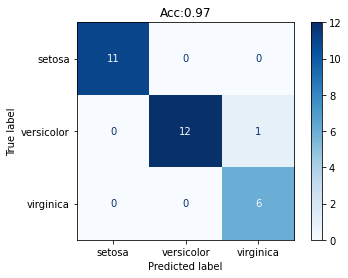

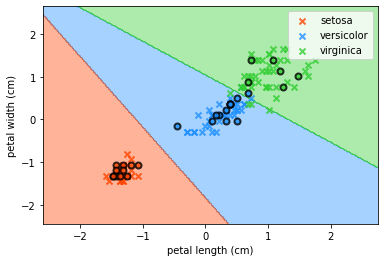

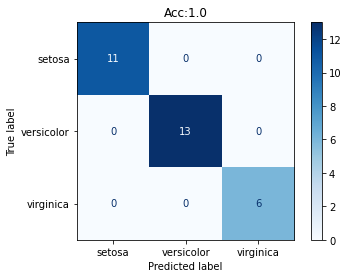

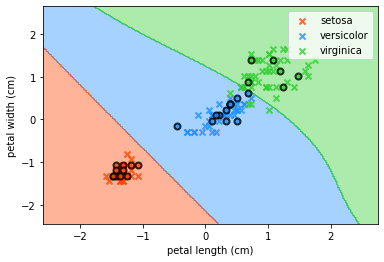

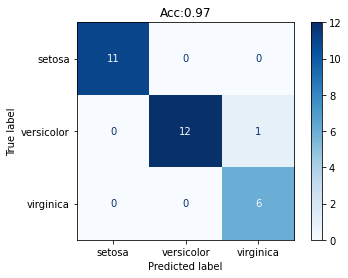

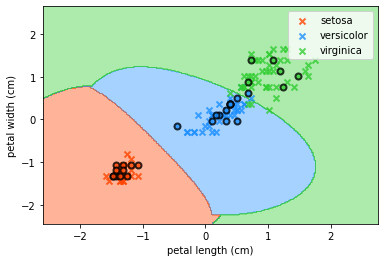

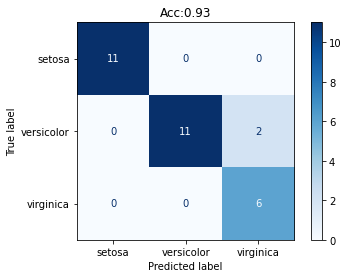

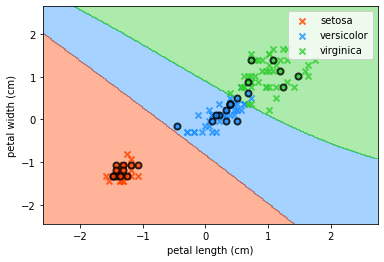

In [ ]:
# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'petal')
# 학습
kernels = ['linear', 'poly', 'rbf', 'sigmoid' ]
for kernel in kernels:
    model = SVC(kernel= kernel, C=1)
    model.fit(X_train, y_train)
    # 정확도 출력 및 혼돈행렬 시각화
    acc = model.score(X_test, y_test)
    draw_cm(model, X_test, y_test, title=f'Acc:{np.round(acc,2)}')
    plt.show()
    # 결정경계 시각화
    draw_decision_region(model, X_train, y_train,
                        X_test, y_test,
                        features=columns,
                        labels=labels)
    plt.show()

### **| XOR 문제 풀기**




* 데이터 생성


```
np.random.seed(5)
X_xor = np.random.randn(200,2)
y_xor = np.logical_xor(X_xor[:,0]>0, X_xor[:,1]>0)
y_xor = np.where(y_xor, 1, 0)
```

(200, 2) (200,)


ValueError: ignored

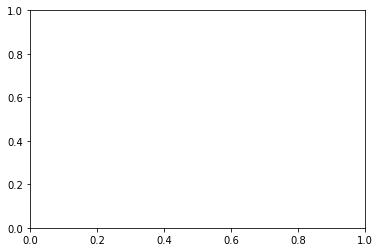

In [ ]:
np.random.seed(5)
X_xor = np.random.randn(200,2)
y_xor = np.logical_xor(X_xor[:,0]>0, X_xor[:,1]>0)
y_xor = np.where(y_xor, 1, 0)

print(X_xor.shape, y_xor.shape)

plt.scatter(X_xor[:0], X_xor[:1], c=y_xor)

* kernel =  ['linear', 'poly', 'rbf', 'sigmoid'] 각각에 대해 결정경계 시각화

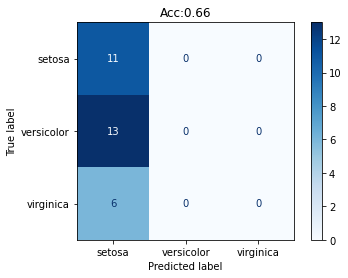

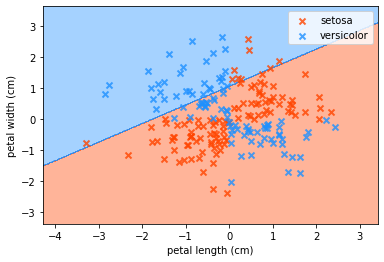

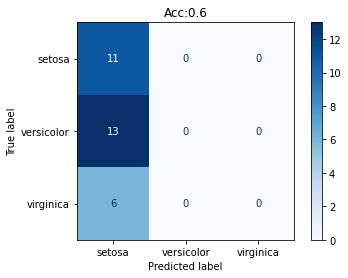

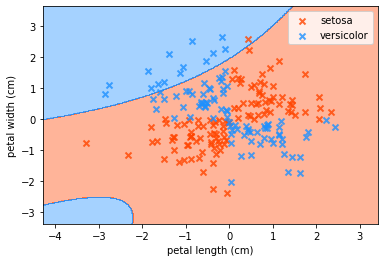

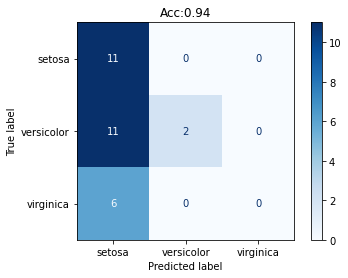

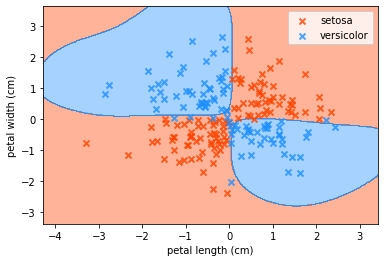

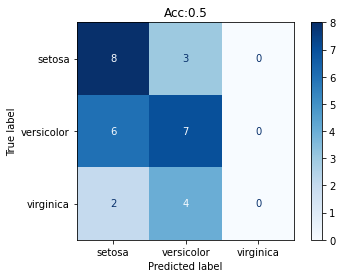

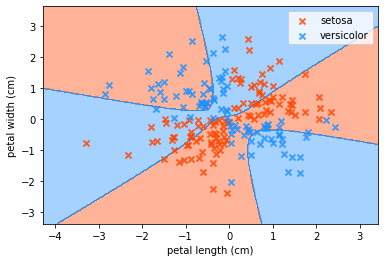

In [ ]:
# 학습
kernels = ['linear', 'poly', 'rbf', 'sigmoid' ]
for kernel in kernels:
    model = SVC(kernel= kernel, C=1)
    model.fit(X_xor, y_xor)
    # 정확도 출력 및 혼돈행렬 시각화
    acc = model.score(X_xor, y_xor)
    draw_cm(model, X_test, y_test, title=f'Acc:{np.round(acc,2)}')
    plt.show()
    # 결정경계 시각화
    draw_decision_region(model, X_xor, y_xor,
                        features=columns,
                        labels=labels)
    plt.show()

#### **`gamma` 값 조절하여 과적합 개념 이해하기**

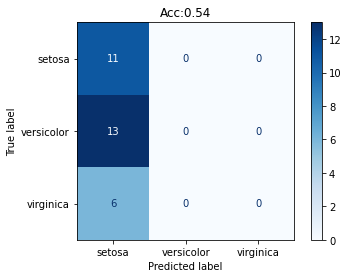

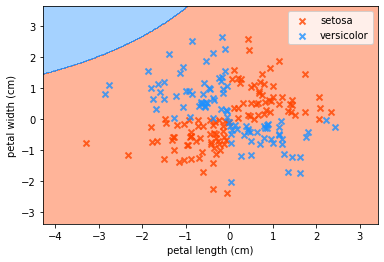

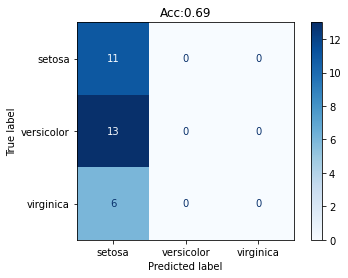

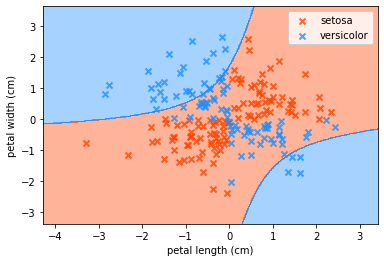

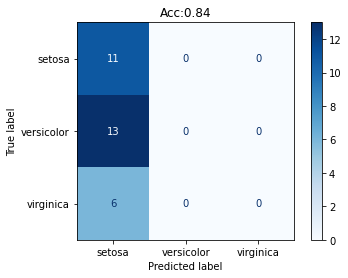

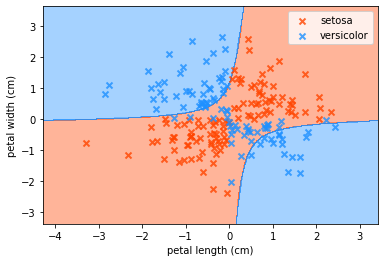

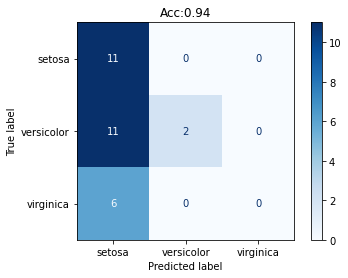

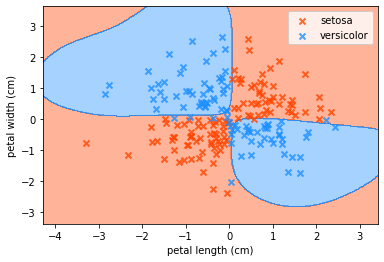

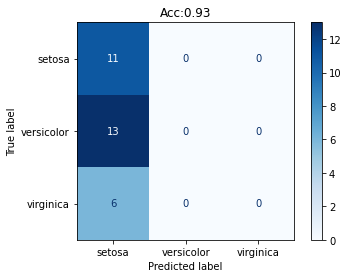

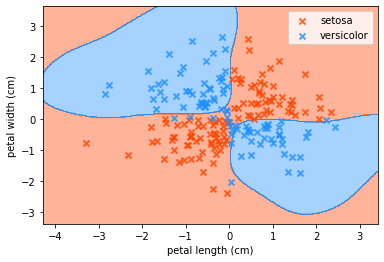

In [ ]:
# 학습
gammas = [0.01,0.05, 0.1, 0.5,1]
for gamma in gammas:
    model = SVC(kernel= "rbf", C=1, gamma=gamma)
    model.fit(X_xor, y_xor)
    # 정확도 출력 및 혼돈행렬 시각화
    acc = model.score(X_xor, y_xor)
    draw_cm(model, X_test, y_test, title=f'Acc:{np.round(acc,2)}')
    plt.show()
    # 결정경계 시각화
    draw_decision_region(model, X_xor, y_xor,
                        features=columns,
                        labels=labels)
    plt.show()

#### **규제를 사용하여 과대적합 피하기**

* Regularization: 파라미터 값이 과도해지는 것을 제한하기 위한 추가 항


$J(w) = \sum_i^n[-y^{(i)}log(\sigma(z^{(i)}))-(1-y^{(i)})log(1-\sigma(z^{(i)}))]+\frac{\lambda}{2}||w||^2$

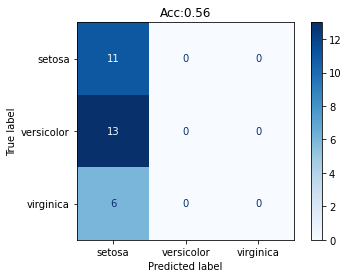

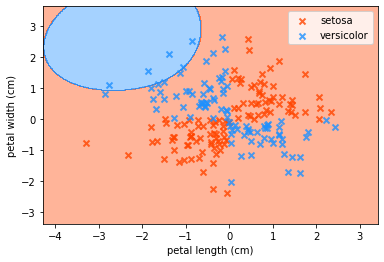

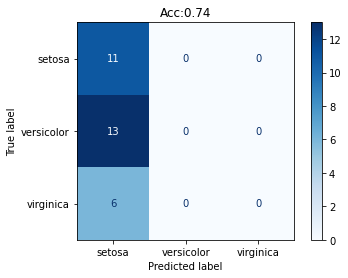

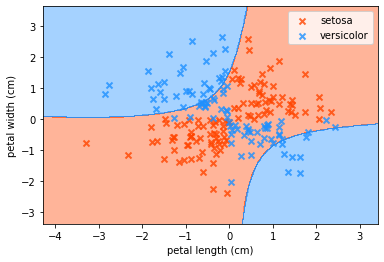

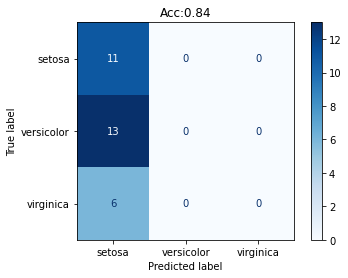

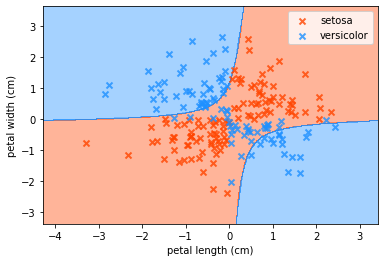

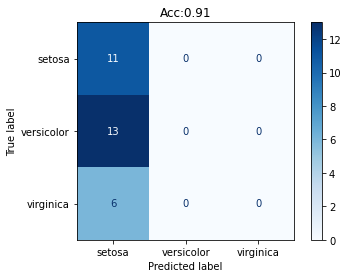

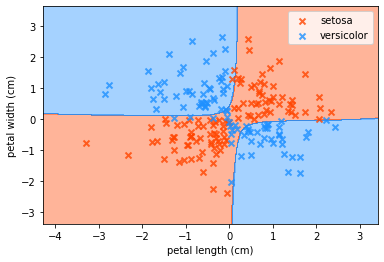

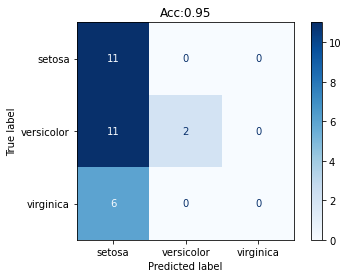

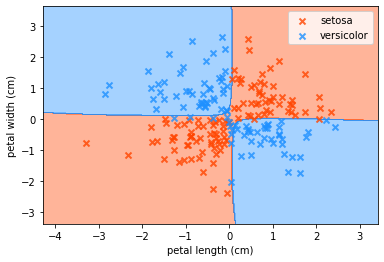

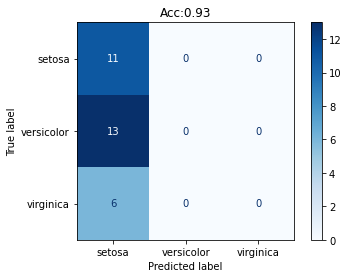

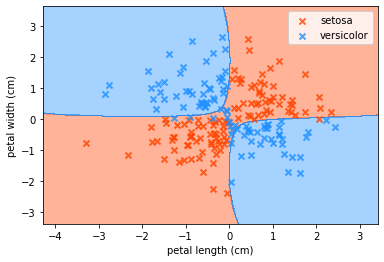

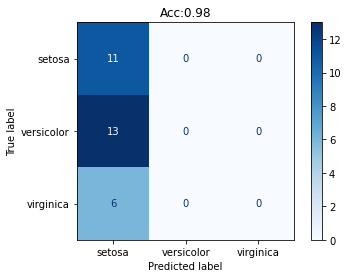

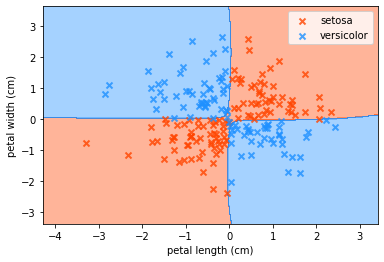

In [ ]:
# 학습
Cs = [0.1,0.5,1,5,10,100,1000]
gammas = [0.01,0.05, 0.1, 0.5,1]
for C in Cs:
    model = SVC(kernel= "rbf", C=C, gamma=0.1)
    model.fit(X_xor, y_xor)
    # 정확도 출력 및 혼돈행렬 시각화
    acc = model.score(X_xor, y_xor)
    draw_cm(model, X_test, y_test, title=f'Acc:{np.round(acc,2)}')
    plt.show()
    # 결정경계 시각화
    draw_decision_region(model, X_xor, y_xor,
                        features=columns,
                        labels=labels)
    plt.show()

* 적절한 하이퍼 파라미터 적용

## **과제1: 펭귄데이터셋 분류**
---
```
df = sns.load_dataset('penguins')
df.shape
```
* 펭귄데이터셋을 불러오고 간단히 전처리 후 멀티클래스 분류를 진행합니다.
* 세 종류의 알고리즘을 사용해 보세요
* 각 알고리즘의 하이퍼파라미터를 조정해 가며 성능을 비교해 보세요.

In [ ]:
import seaborn as sns
df = sns.load_dataset('penguins')
print(df.shape)
df.info()

(344, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


전처리
* 결측치 제거

In [ ]:
df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [ ]:
df[df["sex"].isnull()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


In [ ]:
df = df[~df["sex"].isnull()]
df.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
l_f = ["species","island","sex"]
le = LabelEncoder()
for f in l_f:
    df[f] = le.fit_transform(df[f])
df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,1
1,0,2,39.5,17.4,186.0,3800.0,0
2,0,2,40.3,18.0,195.0,3250.0,0


In [ ]:
X = df.drop("species",axis=1)
y = df["species"]

In [ ]:
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=0.2)

In [ ]:
X_train

array([[ 0.41628329,  1.15877126,  0.78285325, -0.21078541, -0.52791977,
        -1.00754728],
       [ 0.41628329, -0.87345405,  2.01625283, -0.35510695, -0.05700542,
         0.99250926],
       [ 1.78333706, -0.81802972,  0.1147618 , -1.07671467, -0.49652548,
        -1.00754728],
       ...,
       [-0.95077048, -1.7417685 ,  0.47450335, -1.0045539 , -1.6267199 ,
        -1.00754728],
       [ 0.41628329, -1.07667658,  0.2175451 , -1.0045539 , -0.96743982,
        -1.00754728],
       [-0.95077048,  2.06403526, -0.60472129,  2.09835927,  2.07780628,
         0.99250926]])

In [ ]:
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

In [ ]:
y_train

219    1
35     0
1      0
319    2
30     0
      ..
147    0
52     0
54     0
134    0
335    2
Name: species, Length: 266, dtype: int64

In [ ]:
for i in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    LR = LogisticRegression(solver=i)
    model.fit(X_train, y_train)
    # 성능 평가 (분류: accuracy)
    print("solver=",i,"    \t",'Acc:', model.score(X_test, y_test))

solver= newton-cg     	 Acc: 0.9701492537313433
solver= lbfgs     	 Acc: 0.9850746268656716
solver= liblinear     	 Acc: 0.9850746268656716
solver= sag     	 Acc: 0.9701492537313433
solver= saga     	 Acc: 0.9850746268656716


In [ ]:

for i in [2,3,4,5,6,7,8]:
    model = DecisionTreeClassifier(criterion='gini', 
                                max_depth=i)
    model.fit(X_train, y_train)
    # 정확도 출력 및 혼돈행렬 시각화
    print("max_depth=",i,'Acc:', model.score(X_test, y_test))

max_depth= 2 Acc: 0.9701492537313433
max_depth= 3 Acc: 0.9701492537313433
max_depth= 4 Acc: 0.9850746268656716
max_depth= 5 Acc: 0.9850746268656716
max_depth= 6 Acc: 0.9850746268656716
max_depth= 7 Acc: 0.9850746268656716
max_depth= 8 Acc: 0.9850746268656716


In [ ]:
for i in ['linear', 'poly', 'rbf', 'sigmoid']:
    # 학습
    model = SVC(kernel= i, C=1)
    model.fit(X_train, y_train)
    # 정확도 출력 및 혼돈행렬 시각화
    print("kernel=",i,'Acc:', model.score(X_test, y_test))

for i in [0.1,0.5,1,5,10,50,100,500,1000]:
    # 학습
    model = SVC(kernel= "rbf", C=i)
    model.fit(X_train, y_train)
    # 정확도 출력 및 혼돈행렬 시각화
    print("C=",i,'Acc:', model.score(X_test, y_test))

model = SVC(kernel= "rbf", C=1)
model.fit(X_train, y_train)
# 정확도 출력 및 혼돈행렬 시각화
print()
print('Acc:', model.score(X_test, y_test))

kernel= linear Acc: 0.9850746268656716
kernel= poly Acc: 0.9850746268656716
kernel= rbf Acc: 1.0
kernel= sigmoid Acc: 0.9850746268656716
C= 0.1 Acc: 0.9850746268656716
C= 0.5 Acc: 0.9850746268656716
C= 1 Acc: 1.0
C= 5 Acc: 0.9850746268656716
C= 10 Acc: 0.9850746268656716
C= 50 Acc: 0.9701492537313433
C= 100 Acc: 0.9701492537313433
C= 500 Acc: 0.9701492537313433
C= 1000 Acc: 0.9701492537313433

Acc: 1.0


## **과제2: 타이타닉 : 누가 살아남았을까?**
---

* https://dacon.io/competitions/open/235539/data
* 수업 시간에 배운 내용들을 적용하여 이진분류를 진행하고 리더보드에 결과를 제출합니다.
* 평가 지표는 AUC 이지만 아직 배우지 않은 내용이므로, 우선 정확도로 평가하세요

In [ ]:
import pandas as pd
df1 = pd.read_csv("train.csv")
df2 = pd.read_csv("test.csv")
all_data = pd.concat([df1,df2],ignore_index=True)
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
all_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [ ]:
all_data["Age"] = all_data["Age"].fillna(all_data["Age"].median())
all_data["Fare"] = all_data["Fare"].fillna(all_data["Fare"].median())

In [ ]:
all_data["Embarked"].describe()

count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object

In [ ]:
all_data["Embarked"].fillna("S",inplace=True)

In [ ]:
all_data["Cabin"][~all_data["Cabin"].isnull()]=1
all_data["Cabin"][all_data["Cabin"].isnull()]=0
all_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8.0500,0,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,1,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,0,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,28.0,0,0,359309,8.0500,0,S


In [ ]:
all_data["Sex"][all_data["Sex"]=="male"]=1
all_data["Sex"][all_data["Sex"]=="female"]=0
all_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",1,28.0,0,0,A.5. 3236,8.0500,0,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,1,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,0,S
1307,1308,NaN,3,"Ware, Mr. Frederick",1,28.0,0,0,359309,8.0500,0,S


In [ ]:
all_data["family"]=all_data["SibSp"]+all_data["Parch"]

In [ ]:
all_data["solo"]=all_data["family"].copy()

In [ ]:
all_data["solo"][all_data["solo"]!=0] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
all_data["old"] = all_data["Age"].copy()

In [ ]:
all_data["old"][all_data["old"] < 18] = 0
all_data["old"][all_data["old"] >= 18] = 1
all_data["old"] = all_data["old"].astype("int")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
all_data["Embarked"][all_data["Embarked"]=="S"]=0
all_data["Embarked"][all_data["Embarked"]=="C"]=1
all_data["Embarked"][all_data["Embarked"]=="Q"]=2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [ ]:
all_data["class"] = all_data["Name"].map(lambda x:x.split()[1])
all_data["class"] = all_data["class"].str.replace(".","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [ ]:
all_data["class"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Planke,', 'Don', 'Rev',
       'Billiard,', 'der', 'Walle,', 'Dr', 'Pelsmaeker,', 'Mulder,', 'y',
       'Steen,', 'Carlo,', 'Mme', 'Impe,', 'Ms', 'Major', 'Gordon,',
       'Messemaeker,', 'Mlle', 'Col', 'Capt', 'Velde,', 'the', 'Shawah,',
       'Jonkheer', 'Melkebeke,', 'Cruyssen,', 'Khalil,', 'Palmquist,',
       'Brito,'], dtype=object)

In [ ]:
def class_num(x):
    if x=="Mr":
        return 0
    elif x=="Mrs":
        return 1
    elif x=="Miss":
        return 2
    elif x=="Ms":
        return 1
    else:
        return 3
all_data["class"] = all_data["class"].map(lambda x: class_num(x))

In [ ]:
all_data = pd.concat([all_data,pd.get_dummies(all_data["Pclass"],prefix="Pclass")],axis=1)
all_data = pd.concat([all_data,pd.get_dummies(all_data["class"],prefix="class")],axis=1)

In [ ]:
all_data = all_data.drop(["PassengerId", "Name", "SibSp","Parch","Ticket","Pclass","class"],axis=1)

In [ ]:
all_data

,Survived,Sex,Age,Fare,Cabin,Embarked,family,solo,old,Pclass_1,Pclass_2,Pclass_3,class_0,class_1,class_2,class_3
0,0.0,1,22.0,7.2500,0,0,1,1,1,0,0,1,1,0,0,0
1,1.0,0,38.0,71.2833,1,1,1,1,1,1,0,0,0,1,0,0
2,1.0,0,26.0,7.9250,0,0,0,0,1,0,0,1,0,0,1,0
3,1.0,0,35.0,53.1000,1,0,1,1,1,1,0,0,0,1,0,0
4,0.0,1,35.0,8.0500,0,0,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,1,28.0,8.0500,0,0,0,0,1,0,0,1,1,0,0,0
1305,NaN,0,39.0,108.9000,1,1,0,0,1,1,0,0,0,0,0,1
1306,NaN,1,38.5,7.2500,0,0,0,0,1,0,0,1,1,0,0,0
1307,NaN,1,28.0,8.0500,0,0,0,0,1,0,0,1,1,0,0,0


In [ ]:
all_data_X = all_data.drop("Survived", axis=1)
all_data_y = all_data["Survived"]

In [ ]:
ss = StandardScaler()
ss.fit_transform(all_data_X)

array([[ 0.74349692, -0.58162831, -0.50329106, ..., -0.41585943,
        -0.49306684, -0.32348315],
       [-1.34499549,  0.65865194,  0.73474365, ...,  2.40465869,
        -0.49306684, -0.32348315],
       [-1.34499549, -0.27155825, -0.49024046, ..., -0.41585943,
         2.02812259, -0.32348315],
       ...,
       [ 0.74349692,  0.6974107 , -0.50329106, ..., -0.41585943,
        -0.49306684, -0.32348315],
       [ 0.74349692, -0.11652322, -0.48782368, ..., -0.41585943,
        -0.49306684, -0.32348315],
       [ 0.74349692, -0.11652322, -0.21118368, ..., -0.41585943,
        -0.49306684,  3.0913511 ]])

In [ ]:
len(df1)
X = all_data_X[:891].copy()
X_test = all_data_X[891:].copy()

In [ ]:
y = all_data_y[:891].copy()
y = y.astype("int")

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

for i in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    LR = LogisticRegression(solver=i)
    model.fit(X_train, y_train)
    # 성능 평가 (분류: accuracy)
    print("solver=",i,"    \t",'Acc:', model.score(X_val, y_val))
    
for i in [2,3,4,5,6,7,8]:
    model = DecisionTreeClassifier(criterion='gini', 
                                max_depth=i)
    model.fit(X_train, y_train)
    # 정확도 출력 및 혼돈행렬 시각화
    print("max_depth=",i,'Acc:', model.score(X_val, y_val))
    
for i in ['linear', 'poly', 'rbf', 'sigmoid']:
    # 학습
    model = SVC(kernel= i, C=1)
    model.fit(X_train, y_train)
    # 정확도 출력 및 혼돈행렬 시각화
    print("kernel=",i,'Acc:', model.score(X_val, y_val))

save_c = 0
save_score =0
for i in [0.1,0.5,1,5,10,50,100,500,1000]:
    # 학습
    model = SVC(kernel= "rbf", C=i)
    model.fit(X_train, y_train)
    temp_score = model.score(X_val, y_val)
    # 정확도 출력 및 혼돈행렬 시각화
    print("C=",i,'Acc:',temp_score)
    if temp_score>save_score:
        save_score= temp_score.copy()
        save_c=i

solver= newton-cg     	 Acc: 0.8100558659217877
solver= lbfgs     	 Acc: 0.8100558659217877
solver= liblinear     	 Acc: 0.8100558659217877
solver= sag     	 Acc: 0.8100558659217877
solver= saga     	 Acc: 0.8100558659217877
max_depth= 2 Acc: 0.7877094972067039
max_depth= 3 Acc: 0.8156424581005587
max_depth= 4 Acc: 0.8156424581005587
max_depth= 5 Acc: 0.7877094972067039
max_depth= 6 Acc: 0.8212290502793296
max_depth= 7 Acc: 0.8268156424581006
max_depth= 8 Acc: 0.8100558659217877
kernel= linear Acc: 0.7821229050279329
kernel= poly Acc: 0.6703910614525139
kernel= rbf Acc: 0.7150837988826816
kernel= sigmoid Acc: 0.6033519553072626
C= 0.1 Acc: 0.6871508379888268
C= 0.5 Acc: 0.7094972067039106
C= 1 Acc: 0.7150837988826816
C= 5 Acc: 0.7597765363128491
C= 10 Acc: 0.776536312849162
C= 50 Acc: 0.7988826815642458
C= 100 Acc: 0.7988826815642458
C= 500 Acc: 0.8044692737430168
C= 1000 Acc: 0.8100558659217877


In [ ]:
model = DecisionTreeClassifier(criterion='gini', 
                            max_depth=i)
model.fit(X_train, y_train)

1000

In [ ]:
model = DecisionTreeClassifier(criterion='gini', max_depth=7)
model.fit(X, y)
model.predict(X_test)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
submission = pd.read_csv("submission.csv")

In [ ]:
submission["Survived"] = model.predict(X_test)

In [ ]:
submission.to_csv("submission_try2.csv",index=False)

In [ ]:
pd.read_csv("submission_try2.csv")

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
from sklearn.preprocessing import StandardScaler